In [2]:
import sys
import copy
import random
import hashlib
import cupy as cp 
import numpy as np
from math import pi
import numpy.linalg as LA 
import scipy.linalg as spla

from os.path import abspath, join, expanduser
sys.path.append(abspath(join('..')))
sys.path.append(abspath(join('../..')))

from datetime import datetime
from os.path import expanduser

from matplotlib import projections
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from LevelSetPy.Grids import *
from LevelSetPy.Utilities import *
from LevelSetPy.DDPReach import *
from LevelSetPy.Visualization import *
from LevelSetPy.DynamicalSystems import *
from LevelSetPy.BoundaryCondition import *
from LevelSetPy.InitialConditions import *
from LevelSetPy.SpatialDerivative import *
from LevelSetPy.ExplicitIntegration import *
from BRATVisualization.rcbrt_visu import RCBRTVisualizer

%matplotlib inline

In [3]:
args = Bundle(dict(direction=True, visualize=True, elevation=5, azimuth=15, pause_time=.3))

### Levelset Implementation

In [4]:
u_bound = 1
w_bound = 1
a = 64
fontdict = {'fontsize':16, 'fontweight':'bold'}

def preprocessing():
	global u_bound, w_bound

	grid_min = expand(np.array((-a, -a, -pi/2)), ax = 1)
	grid_max = expand(np.array((a, a, pi/2)), ax = 1)
	pdDims = 3                      # 3rd dimension is periodic
	resolution = 100
	N = np.array(([[
					resolution, resolution,
					resolution
					]])).T.astype(int)
	g = createGrid(grid_min, grid_max, N, pdDims)

	axis_align, center, radius = 2, np.zeros((3, 1)), 1.5
	value_init = shapeCylinder(g, axis_align, center, radius)

	return g, value_init
g, value_init = preprocessing()

In [5]:

rocket_rel = RocketSystemRel(g, u_bound, w_bound)

# after creating value function, make state space cupy objects
g.xs = [cp.asarray(x) for x in g.xs]
finite_diff_data = Bundle(dict(innerFunc = termLaxFriedrichs,
            innerData = Bundle({'grid': g,
                'hamFunc': rocket_rel.hamiltonian,
                'partialFunc': rocket_rel.dissipation,
                'dissFunc': artificialDissipationGLF,
                'CoStateCalc': upwindFirstENO2,
                }),
                positive = args.direction,  # direction to grow the updated level set
            ))

t_range = [0, 2.5]

In [6]:
# Visualization paramters
spacing = tuple(g.dx.flatten().tolist())
init_mesh = implicit_mesh(value_init, level=0, spacing=spacing, edge_color='m', face_color='white')
params = Bundle(
                {"grid": g,
                    'disp': True,
                    'labelsize': 16,
                    'labels': "Initial 0-LevelSet",
                    'linewidth': 2,
                    'data': value_init,
                    'elevation': 30,
                    'azimuth': 30,
                    'mesh': init_mesh,
                    'init_conditions': False,
                    'pause_time': args.pause_time,
                    'level': 0, # which level set to visualize
                    'winsize': (16,9),
                    'fontdict': Bundle({'fontsize':18, 'fontweight':'bold'}),
                    "savedict": Bundle({"save": False,
                                "savename": "dint_basic.jpg",
                                "savepath": join(expanduser("~"),
                                "Documents/Papers/Safety/TAC_DDP/figures")
                                })
                })
args.spacing = spacing
args.init_mesh = init_mesh; args.params = params

In [7]:
# load all brts in memory
rocket_brts = np.load("../data/rocket.npz")['brt']

rocket_brts.shape

(11, 100, 100, 100)

In [8]:
plot_dump_dir = join(expanduser('~'), 'Documents', 'Papers', 'Safety', 'DDPReach', 'figures')

In [9]:
def plot_separate(brt, title=rf'Initial BRT', save=True, savename='rocket_zerolev.jpg'):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot(111, projection='3d')

    mesh = implicit_mesh(brt, level=0, spacing=spacing, edge_color='m', face_color='white')
    ax.add_collection3d(mesh.mesh)

    xlim = (mesh.verts[:, 0].min(), mesh.verts[:,0].max())
    ylim = (mesh.verts[:, 1].min(), mesh.verts[:,1].max())
    zlim = (mesh.verts[:, 2].min(), mesh.verts[:,2].max())

    ax.set_xlim3d(*xlim)
    ax.set_ylim3d(*ylim)
    ax.set_zlim3d(*zlim)

    ax.view_init(elev=30, azim=30)

    # ax.axes.get_xaxis().set_ticks([])
    # ax.axes.get_yaxis().set_ticks([])
    ax.tick_params(axis='both', which='minor', labelsize=18)
    ax.set_title(title, fontdict=params.fontdict.__dict__)

    ax.set_xlabel(rf'x$_1$ (ft)', fontdict=params.fontdict.__dict__)
    ax.set_ylabel(rf'x$_2$ (ft)', fontdict=params.fontdict.__dict__)
    ax.set_zlabel(rf'$\omega$ (rad)',fontdict=params.fontdict.__dict__)

    if save:
        plt.savefig(join(plot_dump_dir, savename), bbox_inches='tight') 
    plt.show()

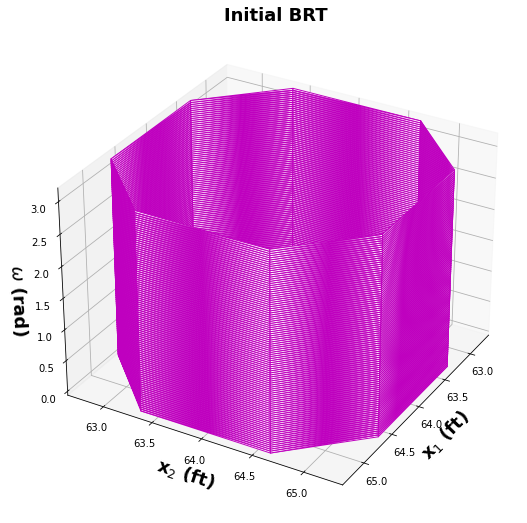

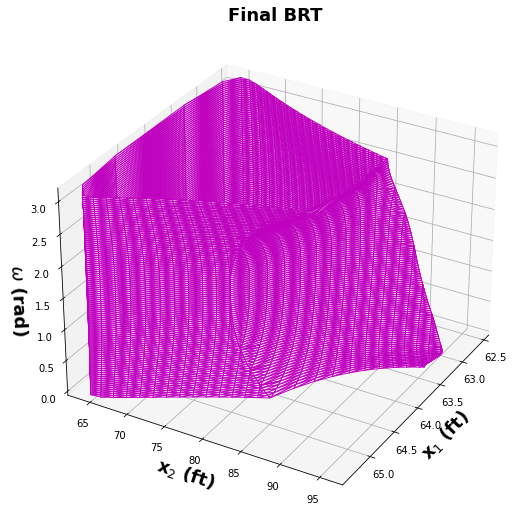

In [17]:
plot_separate(value_init)
plot_separate(rocket_brts[-1], savename="rocket_ls_final.jpg", title="Final BRT")

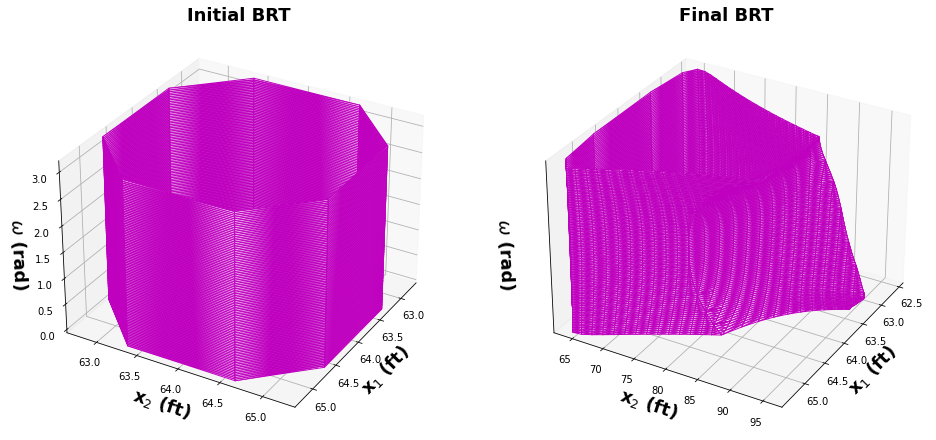

In [10]:
first_brt = rocket_brts[0]

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(121, projection='3d')

mesh = implicit_mesh(value_init, level=0, spacing=spacing, edge_color='m', face_color='white')
ax.add_collection3d(mesh.mesh)

xlim = (mesh.verts[:, 0].min(), mesh.verts[:,0].max())
ylim = (mesh.verts[:, 1].min(), mesh.verts[:,1].max())
zlim = (mesh.verts[:, 2].min(), mesh.verts[:,2].max())

ax.set_xlim3d(*xlim)
ax.set_ylim3d(*ylim)
ax.set_zlim3d(*zlim)

ax.view_init(elev=30, azim=30)

# ax.axes.get_xaxis().set_ticks([])
# ax.axes.get_yaxis().set_ticks([])
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.set_title(rf'Initial BRT', fontdict=params.fontdict.__dict__)

ax.set_xlabel(rf'x$_1$ (ft)', fontdict=params.fontdict.__dict__)
ax.set_ylabel(rf'x$_2$ (ft)', fontdict=params.fontdict.__dict__)
ax.set_zlabel(rf'$\omega$ (rad)',fontdict=params.fontdict.__dict__)
#ax.set_title("Last Time Step's BRT", fontdict = params.fontdict.__dict__)

# plt.savefig(join(plot_dump_dir, 'rocket_zerolev.jpg'), bbox_inches='tight') 

# pick the last time step BRt and plot it
last_brt = rocket_brts[-1]

# fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(122, projection='3d')

mesh = implicit_mesh(last_brt, level=0, spacing=spacing, edge_color='m', face_color='white')
ax.add_collection3d(mesh.mesh)

xlim = (mesh.verts[:, 0].min(), mesh.verts[:,0].max())
ylim = (mesh.verts[:, 1].min(), mesh.verts[:,1].max())
zlim = (mesh.verts[:, 2].min(), mesh.verts[:,2].max())

ax.set_xlim3d(*xlim)
ax.set_ylim3d(*ylim)
ax.set_zlim3d(*zlim)

ax.view_init(elev=30, azim=30)

ax.axes.get_zaxis().set_ticks([])
#ax.axes.get_yaxis().set_ticks([])
#ax.tick_params(axis='both', which='minor', labelsize=18)
ax.set_title(rf'Final BRT', fontdict=params.fontdict.__dict__)


ax.set_xlabel(rf'x$_1$ (ft)', fontdict=params.fontdict.__dict__)
ax.set_ylabel(rf'x$_2$ (ft)', fontdict=params.fontdict.__dict__)
ax.set_zlabel(rf'$\omega$ (rad)',fontdict=params.fontdict.__dict__)
#ax.set_title("Last Time Step's BRT", fontdict = params.fontdict.__dict__)

# plt.savefig(join(plot_dump_dir, 'rocket_ls_final.jpg'), bbox_inches='tight')

print()

In [ ]:

class VarHJIApprox(RocketSystem):
    def __init__(self, eta=.5, rho=.99, dx=.1, grid=None, X=None):
        super().__init__()
        """
            This class uses iterative dynamic game to compute the level sets of the
            value function for all scheduled trajectories of a dynamical system. For
            details see the following bibliography:

            "A Second-Order  Reachable Sets Computation Scheme via a  Cauchy-Type
            Variational Hamilton-Jacobi-Isaacs Equation." IEEE Letter to Control
            Systems Society, by Lekan Molu.

            Parameters:
            -----------
            Cost improvement params:
                .eta: Stopping condition for backward pass;
                .rho: Regularization condition.
                .dx: delta between every discretization between trajectories that emerge on
                    the state space.
                .grid: Optional. Grid properties as already created by createGrid in the LevelSetPy Toolbox.

            .X: All initial state trajectories that emanate from the state space.
        """
        # set default random seed first
        seed_no = 123
        np.random.seed(seed_no)
        random.seed(seed_no)
        cp.random.seed(seed_no)
        
        # initial condition is chosen as the min of all coordinates of the value
        x0 = [g.vs[i].squeeze()[0] for i in range(len(g.vs))]
        
        # compute subsequent value functions by sampling from interior of initial value function
        
        
        xi = [np.random.choice(g.vs[i].squeeze(), size=1)[0] for i in range(len(g.vs))]

        self.eta = eta
        self.rho = rho

        self.X = X if X else  self.generate_init_conds(dx, grid)


        self.system = RocketSystem()

        # Buffer for all values
        self.value_buf = list()

    def generate_init_conds(self, dx = .1, grid=None):
        """
            This method accumulates all initial trajectories within the
            given bounds of the state space.

            Inputs
            ------
            .dx: delta between every discretization between trajectories that emerge on
                the state space.
            .grid: Optional. Grid properties as already created by createGrid in the LevelSetPy Toolbox.

            Output
            -------
            .X: A Numpy array of all trajectories that emanate as initial conditions from
            the state space.
        """
        # contants
        a = 64 # ft/sec^2
        g = 32 # ft/sec^2
        dx = .1  # state space resolution

        if grid is not None:
            grid_min  = grid.min
            grid_max  = grid.max
        else:
            grid_min = np.array(([0,0, 64, g]))
            grid_max = np.array(([1e5, 1e5, 64, g+20]))

        X = [grid_min]

        while np.any(X[-1]<grid_max):
            X += [X[-1]+dx]

        X = np.array(X)

        # # fix the inconsistencies in (x1, x2, x3, x4)
        indices = [np.nan for idx in range(X.shape[0])]
        for dim in range(X.shape[-1]):
            indices[dim] = X[:,dim]>grid_max[dim]

            # replace trajectories with bounds that exceed max
            # values along respective dimensions
            X[indices[dim],dim] = grid_max[dim]


        return X

    def backward(self, 𝑥𝑖, stop_cond=None):
        """
        Input:
            .𝑥𝑟𝑖 - Given initial condition for trajectory (state)
            .𝜋𝑟𝑖: A tuple of nominal maximizing (u) and
                    minimizing (v) controllers with:
                .𝑢𝑖 - Control input (evader).
                .𝑣𝑖 - Disturbance input (pursuer).
        Output:
            .𝜋𝑖 : A tuple of nominal maximizing (u) and
                    minimizing (v) controllers with:
                .𝑢𝑖 - Global Control input (evader).
                .𝑣𝑖 - Global Disturbance input (pursuer).
        """
        #𝑢𝑟𝑖, 𝑣𝑟𝑖 = 𝜋𝑟𝑖
        for T in range(self.system.T-1, -1, -1):
            𝑢𝑟𝑖 = 1.6-1.58*(T/100.)
            𝑣𝑟𝑖 = 1.6+1.58*(T/100.)

            # generate \dot{𝑥}𝑟𝑖 from dynamics
            dxri = self.system.dynamics(𝑥𝑖, (𝑢𝑟𝑖, 𝑣𝑟𝑖))
            #print(dxri)

            # do $Runge Kutta. Follow the integration from t_0 to t_t.
            xri = self.system.rk4_integration(dxri, (𝑢𝑟𝑖, 𝑣𝑟𝑖))
            # print(T, "|", xri)

            # compute the value and co-state
            self.system.value_funcs(xri, t=T)
            # compute the Hamiltonians w.r.t u, v, and x
            self.system.hamiltonian(xri, (𝑢𝑟𝑖, 𝑣𝑟𝑖), self.system.Vx[T], t=T)

            "Calculate 𝑢∗, 𝑣∗"
            # (i) First get Huu and Hvv's Inverses
            self.system.inversions(T)
            # (ii) Now compute the gains. Note I have removed Hux since it is full of zeros.
            self.system.ku[T] = -self.system.HuuInv[T]@(self.system.Huv[T]@self.system.kv[T] + \
                                (self.system.fu[T].T@self.system.Vxx[T]))
            self.system.kv[T] = -self.system.HvvInv[T]@(self.system.Hvu[T]@self.system.ku[T] + \
                                (self.system.fv[T].T@self.system.Vxx[T]))
            # compute 𝛿𝑥
            𝛿𝑥 = 𝑥𝑖 - 𝑥𝑟𝑖

            # compute 𝛿𝑢, 𝛿𝑣
            𝛿𝑢 = self.system.ku[T]*𝛿𝑥
            𝛿𝑣 = self.system.kv[T]*𝛿𝑥

            if T < 90: break
        # return xi, pol_i


In [ ]:
import numpy as np
from LevelSetPy.Utilities import *
from scipy.linalg import cholesky, LinAlgError, solve_triangular


class RocketSystem():
    def __init__(self, r = 100, \
                  T=100, DX=4, DU=4, DV=4, delta=.01):
        """
            This class sets up the dynamics, value function and Hamiltonian as
            well as their partial derivatives for the differential game between
            two rockets over a shared space in $\mathbb{R}^n$.

            Parameters:
            -----------
              Capture params:
                r: Capture radius.
              Integration/State/Control Parameters:
                .T: Horizon of time in which to integrate the for-back equations.
                .DX: Dimension of the state.
                .DU: Dimension of the control.
                .DV: Dimension of the disturbance.
                .delta: small positive constant in active shift to ensure positive definiteness of Hessian
        """
        # gravitational acceleration, 32.17ft/sec^2
        self.g = 32.17
        # acceleration of the rocket <-- eq 2.3.70 Dreyfus
        self.a = 64.0 #ft/sec^2
        # capture radius
        self.capture_rad = r # ft
        self.delta_uu       = delta
        self.delta_vv       = delta

        self.pre_allocations(T, DX, DU, DV)


    def pre_allocations(self, T, DX, DU, DV):
        """
            Pre-allocate all buffers for every V, H, f and their derivatives.
            Arguments:  Dimensions along time, x u, v respectively.
        """
        # Dimensions along time, x u, v
        self.T, self.DX, self.DU, self.DV = T, DX, DU, DV

        # Allocations
        self.fx = np.zeros((self.T, self.DX,self.DX))
        self.fu = np.zeros((self.T, self.DV))
        self.fv = np.zeros((self.T, self.DV))

        # Gains
        self.ku = np.zeros((self.T, self.DU, self.DU))
        self.kv = np.zeros((self.T, self.DV, self.DV))

        # fill up the Gains
        self.ku.fill(realmin)
        self.kv.fill(realmin)

        # Hamiltonian allocations
        self.H   = np.zeros((self.T))
        self.Hx  = np.zeros((self.T, self.DX))
        self.Hu  = np.zeros((self.T, self.DU))
        self.Hv  = np.zeros((self.T, self.DV))
        self.Hvu = np.zeros((self.T, self.DV, self.DU))
        self.Huv = np.zeros((self.T, self.DU, self.DV))
        self.Hvv = np.zeros((self.T, self.DV, self.DV))
        self.Huu = np.zeros((self.T, self.DU, self.DU))
        self.Hux = np.zeros((self.T, self.DU, self.DX))
        self.Hvx = np.zeros((self.T, self.DV, self.DX))
        self.Hxx = np.zeros((self.T, self.DX, self.DX))

        # Inverses of the Hamiltonians
        self.HvvInv = np.zeros((self.T, self.DV, self.DV))
        self.HuuInv = np.zeros((self.T, self.DU, self.DU))

        # Value functions and their derivatives
        self.V  = np.zeros((self.T))
        self.Vx = np.zeros((self.T, self.DX))
        self.Vxx = np.zeros((self.T, self.DX, self.DX))

    def dynamics(self, x, pol):
        """
            Form:   dx/dt = f(x, u, v)

            The dynamics of the rocket is obtained from Dreyfus' formulation using a first-order Calculus
            of Variation model in 1962 in a RAND Report. This same model was used by S.K. Mitter in
            solving a 2nd-order gradient-based variational problem in 1966 in an Automatica paper.

            Here, we use the Mitter problem as stipulated by Jacobson and Mayne in their
            DDP book in 1970. See equations 2.3.68 through 2.3.75.

            The equations of motion are adopted from Dreyfus' construction as follows:

                &\dot{y}_1 = y_3,          &\dot{y}_5 = y_7, \\
                &\dot{y}_2 = y_4,          &\dot{y}_6 = y_8, \\
                &\dot{y}_3 = a\cos(u),     &\dot{y}_7 = a\cos(v), \\
                &\dot{y}_4 = a\sin(u) - g, &\dot{y}_8 = a\sin(v) - g.

            where $u(t), t \in [-T,0]$ is the controller under the coercion of the evader and
             $v(t), t \in [-T,0]$ is the controller under the coercion of the pursuer i.e.
             the pursuer is minimizing while the evader is maximizing. The full state dynamics
             is given by

            \dot{y} = \left(\begin{array}{c}
                            \dot{y}_1 & \dot{y}_2 & \dot{y}_3 & \dot{y}_4 \\
                            \dot{y}_5 & \dot{y}_6 & \dot{y}_7 &\dot{y}_8 \\
                            \end{array}
                        \right)^T =
                            \left(\begin{array}{c}
                            y_3 & y_4 & a\cos(u) & a\sin(u) - g &
                            y_7 & y_8 & a\cos(v) & a\sin(v) - g
                            \end{array}\right).

            In relative coordinates between the two rockets, we have
                    &\dot{x}_1 = x_3,\\
                    &\dot{x}_2 = x_4,\\
                    &\dot{x}_3 = a\cos(u) - a\cos(v),\\
                    &\dot{x}_4 = a\sin(u) - a\sin(v)

        Parameters
        ==========
            Input:
                .x - state as an initial condition
                .pol: A tuple of maximizing (u) and minimizing (v) controllers where:
                    .u - control input (evader)
                    .v - disturbance input (pursuer)
            Output:
                xdot - System dynamics
        """
        assert isinstance(x, list) or isinstance(x, np.ndarray), "x must be a List or ND-Array."
        assert isinstance(pol, tuple), "Policy passed to <dynamics> must be a Tuple."
        u, v = pol

        xdot = np.array(([x[2], x[3], \
                         self.a*np.cos(u)-self.a*np.cos(v), \
                         self.a*np.sin(u)-self.a*np.sin(v)])).T

        return xdot

    def rk4_integration(self, x0, pol, stepstart = 0, stepsend = 50, time_step = 0.2):
        """
            Compute an approximation to the rhs of an ode using a 4th-order Runge-Kutta
            integration technique/scheme. Equations from: https://lpsa.swarthmore.edu/NumInt/NumIntFourth.html
            Note that this assumes that the system dynamics is of a non-autonomous system.

            Input:
                .x0 -- \equiv x(t_0). Initial condition of the ode to be integrated. Must be a list
                    or Numpy array.
                .steps -- How many steps for RK.
                .time_step -- The number of time per step.
            Output:
                .x  -- The resulting value(s) of the integrated system.
        """
        X = np.asarray(x0) if isinstance(x0, list) else x0

        for _ in range(stepstart, stepsend):
            k1 = self.dynamics(X, pol)                    # {k_1} = f({\hat{x}}({t_0}),{t_0})
            k2 = self.dynamics(X + time_step/2 * k1, pol) # f\left( {\hat{x}({t_0}) + {k_1}{h \over 2},{t_0} + {h \over 2}} \right)
            k3 = self.dynamics(X + time_step/2 * k2, pol) # f\left( {\hat{x}({t_0}) + {k_2}{h \over 2},{t_0} + {h \over 2}} \right)
            k4 = self.dynamics(X + time_step * k3, pol)   # f\left( {\hat{x}({t_0}) + {k_3}h,{t_0} + h} \right)

            # compute a weighted sum of the slopes to obtain the final estimate of \hat{x}(t_0 + h)
            X  = X+(time_step/6)*(k1 +2*k2 +2*k3 +k4)

        return X

    def f_derivs(self, f, pol, t=0):
        """
            This function computes the partials of f w.r.t the state,
            control, and disturbance. The definition of f is in the __doc__ of
            member function <dynamics> above.

            Inputs:
                .f -- System Dynamics
                .pol: A tuple of maximizing (u) and minimizing (v) controllers where:
                    .u - Control input (evader).
                    .v - Disturbance input (pursuer).
                .t - Time step at which to compute f.
            Output: Bundle of all partials of f i.e.:
                    .Bundle(fu, fv, fx)
        """
        assert isinstance(pol, tuple), "pol must be a tuple."
        u, v = pol

        self.fx[:,0,2] = 1
        self.fx[t,1,3] = 1

        self.fu[t,2,0] = -self.a*np.sin(u)
        self.fu[t,3,0] = self.a*np.cos(u)

        self.fv[t,2,0] = self.a*np.sin(v)
        self.fv[t,3,0] = -self.a*np.cos(v)

        # return Bundle(dict(fx=self.fx, fu=self.fu, fv=self.fv)     

    def hamiltonian(self, states, pol, p, t=0):
        '''
            Input:
                .states: The State vector.
                .pol: A tuple of maximizing (u) and minimizing (v) controllers where:
                    .u - control input (evader).
                    .v - disturbance input (pursuer).
                    .t - Time step at which to compute H and its derivatives.
                .p: Costate  vector.
            Output: The Hamiltonian and its derivatives.

            **********************************************************************************
            The Hamiltonian:
                H(x,p) &=  p_1 * x_3 + p_2 * x_4 +
                            p_3*a*(\cos(u) - \cos(v)) + p_4*a*(\sin(u) - \sin(v))

            Derivative w.r.t u terms   &H_u = -p_3*a*\sin(u) + p_4*a*cos(u) \\
                                        &H_{uu} = -p_3*a*\cos(u) - p_4*a*\sin(u) \\
                                        &H_{uv} = \textbf{0}_{4\times4}  \\
                                        &H_{ux} = \textbf{0}_{4\times4}

            Derivative w.r.t v terms   &H_v = p_3*a*\sin(v) - p_4*a*\cos(v) \\
                                        &H_{vv} = p_3*a*\cos(v) + p_4*a*\sin(v) \\
                                        &H_{vu} = \textbf{0}_{4\times4} \\
                                        &H_{vx} = \textbf{0}_{4\times4}

            Derivative w.r.t x terms:  &H_x = \begin{bmatrix}0 &0 &p_1 &p_2 \end{bmatrix}^T \\
                                        &H_{xx} = 0_{4\times4} \\
                                        &H_{xu} = \textbf{0}_{4\times4} \\
                                        &H_{xv} = \textbf{0}_{4\times4}
        '''

        assert isinstance(states, np.ndarray), "The states of the dynamical system must be a list instance."
        assert isinstance(pol, tuple), "Policy input for Hamiltonian Function must be a tuple."
        assert isinstance(p, np.ndarray), "The co-state must be a list instance."
        u, v = pol

        # computations  #TODOs: Broadcast to appropriate Dims
        self.H[t] = p[0]*states[2] + p[1]*states[3] + \
             self.a * p[2]*(np.cos(u)-np.cos(v)) + \
             self.a * p[3]*(np.sin(u)-np.sin(v))

        self.Hu[t] = -p[2] * self.a * np.sin(u) + p[3] * self.a * np.cos(u)
        self.Huu[t] = -p[2] * self.a * np.cos(u) - p[3] * self.a * np.sin(u)

        self.Hv[t] = p[2] * self.a * np.sin(v) - p[3] * self.a * np.cos(v)
        self.Hvv[t] = p[2] * self.a * np.cos(v) + p[3] * self.a * np.sin(v)


        self.Hx[t, 2] = p[0]
        self.Hx[t, 3] = p[1]

    def value_funcs(self, x, t):
        """
            Compute the Value function as well as its partial
            derivatives. Note that the value function is the
            target set parameterized by time and state. The co-state and its 2nd order derivatives
            are matrices.

            Equations
            ---------
            V(x,0) &= \sqrt{x_1^2 + x_2^2} - r

            V_x = \dfrac{2 x_1}{\sqrt{x_1^2 + x_2^2}}{x}_3 +
                    \dfrac{2 x_2}{\sqrt{x_1^2 + x_2^2}}{x}_4;

            V_{xx} &= \dfrac{2 \left[x_1^3+x_2^2(x_2+x_3)+
                        x_1 x_2 (x_2 -x_3 - x_4) +
                        x_1^2(x_2+x_4)\right]}{\left(\sqrt{x1^2 + x2^2}\right)^3}

            Input:
              .x: State vector.
              .t - Time step at which to compute H and its derivatives.
            Output: Bundle of
              .V -- The terminal cost.
              .Vx -- The terminal cost's derivative wrt x.
              .Vxx -- The co-state's Hessian wrt x.
        """
        self.V[t] = np.sqrt(x[0]**2+x[1]**2)-self.capture_rad

        # Todos: Fix the broadcast of V's w.r.t to state
        self.Vx[t,0] = 2*x[0]
        self.Vx[t,1] = 2*x[1]

        #second order derivative
        self.Vxx[t,0,0] = 2
        self.Vxx[t,1,1] = 2

    def active_shift_control(self, T):
        """
            Given a Hamiltonian function that is non-pd, 
            shift the eigen values adaptively to guarantee 
            quadratic convergence.

            For details, see equations 4.3 and 4.4 in Li and Shoemaker.

            What I have implemented is not quite active shift though

            Params:
            =======
                .T: Time index to apply active shift.
        """
        eigvals, eigvecs = spla.eig(self.Huu[T])

        # compute lambda
        min_eig = np.min(eigvals.real)

        eps_active = self.delta_uu - min_eig if min_eig < self.delta_uu else self.delta_uu

        self.delta_uu = eps_active

        self.Huu[T] += eps_active * np.eye(len(self.Huu[T]))

    def active_shift_disturb(self, T):
        """
            Given a Hamiltonian function that is non-pd, 
            shift the eigen values adaptively to guarantee 
            quadratic convergence.

            For details, see equations 4.3 and 4.4 in Li and Shoemaker.

            What I have implemented is not quite active shift though

            Params:
            =======
                .T: Time index to apply active shift.
        """
        eigvals, eigvecs = spla.eig(self.Hvv[T])

        # compute lambda
        min_eig = np.min(eigvals.real)

        eps_active = self.delta_uu - min_eig if min_eig < self.delta_uu else self.delta_uu

        self.delta_uu = eps_active

        self.Hvv[T] += eps_active * np.eye(len(self.Hvv[T]))



In [ ]:
self  = VarHJIApprox()

In [ ]:
def backward(self, 𝑥𝑖, stop_cond=None):
    """
    Input:
        .𝑥𝑟𝑖 - Given initial condition for trajectory (state)
        .𝜋𝑟𝑖: A tuple of nominal maximizing (u) and
                minimizing (v) controllers with:
            .𝑢𝑖 - Control input (evader).
            .𝑣𝑖 - Disturbance input (pursuer).
    Output:
        .𝜋𝑖 : A tuple of nominal maximizing (u) and
                minimizing (v) controllers with:
            .𝑢𝑖 - Global Control input (evader).
            .𝑣𝑖 - Global Disturbance input (pursuer).
    """
    #𝑢𝑟𝑖, 𝑣𝑟𝑖 = 𝜋𝑟𝑖
    Fail_control, Fail_disturb  = True, True
    while Fail_control or Fail_disturb :
        Fail_control, Fail_disturb = False, False

        for T in range(self.system.T-1, -1, -1):
            𝑢𝑟𝑖 = 1.6-1.58*(T/100.)
            𝑣𝑟𝑖 = 1.6+1.58*(T/100.)

            # generate \dot{𝑥}𝑟𝑖 from dynamics
            dxri = self.system.dynamics(𝑥𝑖, (𝑢𝑟𝑖, 𝑣𝑟𝑖))
            #print(dxri)

            # do $Runge Kutta. Follow the integration from t_0 to t_t.
            xri = self.system.rk4_integration(dxri, (𝑢𝑟𝑖, 𝑣𝑟𝑖), 0, 100)
            delta_x = 𝑥𝑖 - xri
            print(T, "|xi ", 𝑥𝑖, "|xri ", xri, "|dx ", delta_x)
            
            
            # compute the value and co-state
            self.system.value_funcs(xri, t=T)
            # compute the Hamiltonians w.r.t u, v, and x
            self.system.hamiltonian(xri, (𝑢𝑟𝑖, 𝑣𝑟𝑖), self.system.Vx[T], t=T)

            "Calculate 𝑢∗, 𝑣∗"
            # (i).a First get Huu Inverse
            try:
                Huu_upper = cholesky(self.Huu[T], lower=False)
                Huu_lower = Huu_upper.T
            except LinAlgError as e:
                debug(f'LinAlgError Failing at Huu Factorization: {e} time {T}')
                Fail_control = True
                break

            try:
                Hvv_upper = cholesky(self.Hvv[T], lower=False)
                Hvv_lower = Hvv_upper.T
            except LinAlgError as e:
                debug(f'LinAlgError Failing at Hvv Factorization: {e} time {T}')
                Fail_disturb = True
                break

            self.HuuInv[T] = solve_triangular(Huu_upper, solve_triangular(Huu_lower, np.eye(Huu_upper.shape[0]), lower=True)) # B above
            self.HvvInv[T] = solve_triangular(Hvv_upper, solve_triangular(Hvv_lower, np.eye(Hvv_upper.shape[0]), lower=True)) # B above

            # Fail_control = self.system.control_inversions(T)
            # # (i).b First get Hvv Inverse
            # Fail_disturb = self.system.disturb_inversions(T)

            # (ii) Now compute the gains. Note I have removed Hux since it is full of zeros.
            self.system.ku[T] = -self.system.HuuInv[T]@(self.system.Huv[T]@self.system.kv[T] + \
                                (self.system.fu[T].T@self.system.Vxx[T]))
            self.system.kv[T] = -self.system.HvvInv[T]@(self.system.Hvu[T]@self.system.ku[T] + \
                                (self.system.fv[T].T@self.system.Vxx[T]))
            # compute 𝛿𝑥
            𝛿𝑥 = 𝑥𝑖 - 𝑥𝑟𝑖

            # compute 𝛿𝑢, 𝛿𝑣
            𝛿𝑢 = self.system.ku[T]*𝛿𝑥
            𝛿𝑣 = self.system.kv[T]*𝛿𝑥
    
        if Fail_control:
            # restart the backward pass with new shifted Hamiltonians
            self.system.active_shift_control(T)
        if Fail_disturb:
            self.system.active_shift_disturb(T)

        #if T < 98: break
    # return xi, pol_i

backward(self, self.X[0])

In [ ]:

class VarHJIApprox(RocketSystem):
    def __init__(self, T = 5, DX=4, DU=4, DV=4, eta=.5, rho=.99, dx=.1, X=None):
        super().__init__()
        """
            This class uses iterative dynamic game to compute the level sets of the
            value function for all scheduled trajectories of a dynamical system. For
            details see the following bibliography:

            "A Second-Order  Reachable Sets Computation Scheme via a  Cauchy-Type
            Variational Hamilton-Jacobi-Isaacs Equation." IEEE Letter to Control
            Systems Society, by Lekan Molu, Ian Abraham, and Sylvia Herbert.

            Parameters:
            -----------
            Cost improvement params:
                .eta: Stopping condition for backward pass;
                .rho: Regularization condition.
                .dx: delta between every discretization between trajectories that emerge on
                    the state space.
                .grid: Optional. Grid properties as already created by createGrid in the LevelSetPy Toolbox.

            .X: All initial state trajectories that emanate from the state space.
        """
        self.eta = eta
        self.rho = rho

        self.system = RocketSystem()

        rc = 1.5
        T, DX, DU, DV = 5, 4, 4, 4
        """
            Pre-allocate all buffers for every V, H, f and their derivatives.
            Arguments:  Dimensions along time, x u, v respectively.
        """
        self.X = X

        # Allocations
        self.fx = np.zeros((T, DX, DX))
        self.fu = np.zeros((T, DU, DU))
        self.fv = np.zeros((T, DV, DV))

        # Gains
        self.ku = np.zeros((T, DU, DU))
        self.kv = np.zeros((T, DV, DV))

        # fill up the Gains
        self.ku.fill(realmin)
        self.X.fll(realmin)
        self.kv.fill(realmin)

        # Hamiltonian allocations
        self.H   = np.zeros((T))
        self.Hr  = np.zeros((T))
        self.Hx  = np.zeros((T, DX))
        self.Hu  = np.zeros((T, DU))
        self.Hv  = np.zeros((T, DV))
        self.Hvu = np.zeros((T, DV, DU))
        self.Huv = np.zeros((T, DU, DV))
        self.Hvv = np.ones((T, DV, DV))
        self.Huu = np.ones((T, DU, DU))
        self.Hux = np.zeros((T, DU, DX))
        self.Hvx = np.zeros((T, DV, DX))
        self.Hxx = np.zeros((T, DX, DX))

        # Inverses of the Hamiltonians
        self.HvvInv = np.zeros((T, DV, DV))
        self.HuuInv = np.zeros((T, DU, DU))

        # Value functions and their derivatives
        self.V  = np.zeros((T))
        self.Vtilde  = np.zeros((T))
        self.Vx = np.zeros((T, DX))
        self.Vxx = np.zeros((T, DX, DX))

        self.ur = np.zeros((T))
        self.vr = np.zeros((T))

    def generate_init_conds(self, dx = .1, grid=None):
        """
            This method accumulates all initial trajectories within the
            given bounds of the state space.

            Inputs
            ------
            .dx: delta between every discretization between trajectories that emerge on
                the state space.
            .grid: Optional. Grid properties as already created by createGrid in the LevelSetPy Toolbox.

            Output
            -------
            .X: A Numpy array of all trajectories that emanate as initial conditions from
            the state space.
        """
        # contants
        a = 64 # ft/sec^2
        g = 32 # ft/sec^2
        dx = .1  # state space resolution

        if grid is not None:
            grid_min  = grid.min
            grid_max  = grid.max
        else:
            grid_min = np.array(([0,0, 64, g]))
            grid_max = np.array(([1e5, 1e5, 64, g+20]))

        X = [grid_min]

        while np.any(X[-1]<grid_max):
            X += [X[-1]+dx]

        X = np.array(X)

        # # fix the inconsistencies in (x1, x2, x3, x4)
        indices = [np.nan for idx in range(X.shape[0])]
        for dim in range(X.shape[-1]):
            indices[dim] = X[:,dim]>grid_max[dim]

            # replace trajectories with bounds that exceed max
            # values along respective dimensions
            X[indices[dim],dim] = grid_max[dim]


        return X

    def dynamics(self, x, u, v, a=32):
        assert x.size==4, "x must be of size 4."

        dyna =  [x[2], x[3], a*np.cos(u)-a*np.cos(v), a*np.sin(u)-a*np.sin(v)]

        return np.asarray(dyna)

    def rk45(self, xdot, dynamics_handle, steps= 300, h =0.2):
        # assert not np.any(cur_state), "current state cannot be empty."

        X = np.asarray(xdot) if isinstance(xdot, list) else xdot

        for j in range(steps):
            k1 = dynamics_handle(X)
            k2 = dynamics_handle(X + h/2 * k1)
            k3 = dynamics_handle(X + h/2 * k2)
            k4 = dynamics_handle(X + h * k3)

            X  = X+(h/6)*(k1 +2*k2 +2*k3 +k4)

        return X

    def value_funcs(self, x, rc=1.5):
        assert x.size==4, "x must be at least of size 4"
        x1, x2, x3, x4 = x[0], x[1], x[2], x[3]

        V = np.sqrt(x[0]**2 + x[1]**2) - rc
        Vx = np.array([x1/(np.sqrt(x1**2+x2**2)), x2/(np.sqrt(x1**2+x2**2)), 0, 0 ])
        Vxx = np.array([
                        [x1**2/((np.sqrt(x1**2+x2**2))**3), x1*x2/((np.sqrt(x1**2+x2**2))**3), 0, 0 ],
                        [-x1*x2/((np.sqrt(x1**2+x2**2))**3), x1**2/((np.sqrt(x1**2+x2**2))**3), 0, 0 ],
                        [0, 0, 0, 0 ],
                        [0, 0, 0, 0 ],
        ])

        return V, Vx, Vxx

    def rk45_vee(self, X, steps= 300, h =0.2):
        for j in range(steps):
            k1 = -np.minimum(0, X)
            k2 = -np.minimum(0, X + h/2 * k1)
            k3 = -np.minimum(0, X + h/2 * k2)
            k4 = -np.minimum(0, X + h * k3)

            X = X+(h/6)*(k1 + 2*k2 + 2*k3 + k4)

        return X     

    def deg2rad(self, x):
        return x*np.pi/180

    def backpass(self, x0):
        # backward pass

        x = np.array([1000, 1000, 4, 4], dtype=np.float64)

        for t in range(self.T-1, -1, -1):
            self.ur[t] = 1.6 - 1.5*(t/100)
            self.vr[t] = -self.ur[t]

            "Using the nominal control \bar{u}==1, run a nominal trajectory"
            # run xbar with nominal control-disturbance pair
            x_bar_dot = self.dynamics(x, u=self.ur[t], v=self.vr[t])
            dh = lambda x: self.dynamics(x, u=self.ur[t], v=self.vr[t])

            # integrate x_bar_dot
            x_bar = self.rk45(x_bar_dot, dh, steps=300, h=0.01)
            # print(f"-----------------------t={t}-------------------------------")
            # print('Nominal trajectory: ', x_bar)

            # calculate the nominal cost V:
            Vbar = np.sqrt(x_bar[0]**2 + x_bar[1]**2 - self.rc)
            # print("Vbar: ", Vbar)

            delta_x = x0 - x_bar
            # print("delta_x:, ", delta_x)

            # compute the Hamiltonian, H under linearized controls u_r, v_r
            v, p, vxx = self.value_funcs(x_bar, self.rc)
            self.V[t]    = v 
            self.Vx[t]   = p
            self.Vxx[t]  = vxx 

            # update partial derivatives
            self.fx[t][0, 2] = 1
            self.fx[t][1, 3] = 1

            self.fu[t][2, 2] = -a * np.sin(self.ur[t])
            self.fu[t][3, 2] = a * np.cos(self.ur[t])
            
            self.fv[t][2, 3] = a * np.sin(self.ur[t])
            self.fv[t][3, 3] = -a * np.cos(self.vr[t])

            self.Hr[t]   = p[0]*x_bar[2] + p[1]*x_bar[3] + p[2]*a*(np.cos(self.ur[t]) - np.cos(self.vr[t])) + p[3]*a*(np.sin(self.ur[t]) - np.sin(self.vr[t]))
            self.H[t]    = p[0]*x[2]     + p[1]*x[3]     + p[2]*a*(np.cos(self.ur[t]) - np.cos(self.vr[t])) + p[3]*a*(np.sin(self.ur[t]) - np.sin(self.vr[t]))
            self.Hx[t]   = np.array([0, 0, p[0], p[1]])
            # Hamiltonian control derivs
            self.Hu[t][2]   = -a*p[2]*np.sin(self.ur[t]) + a*p[3]*np.cos(self.ur[t])
            self.Hv[t][2]   = a*p[2]*np.sin(self.vr[t]) - a*p[3]*np.sin(self.ur[t])
            # Hamiltonian Hessians for controls
            self.Huu[t]    *= -a*p[2]*np.cos(self.ur[t]) - a*p[3]*np.sin(self.ur[t])
            self.Hvv[t]    *= a*p[2]*np.cos(self.vr[t]) + a*p[3]*np.sin(self.vr[t])
            
            # gains
            # ku[t]   = -(1/Huu[t])@(Huv[t]@kv[t]+(Hux[t]+fu[t].T@Vxx[t]))
            # ku[t]   = -(1/Hvv[t])@(Hvu[t]@ku[t]+(Hvx[t]+fv[t].T@Vxx[t]))

            f       = self.dynamics(x, 100, 0.01)
            f_r     = self.dynamics(x_bar, 100, 0.01)
            self.fu[t][2]   = -a*np.sin(self.ur[t]); 
            self.fu[t][3]   = a*np.cos(self.ur[t])
            self.fv[t][2]   = a*np.sin(self.vr[t]); 
            self.fv[t][3]   = -a*np.cos(self.vr[t])

            Vtilde_dot = -np.minimum(0, self.H[t]-self.Hr[t])
            Vx_dot     = -np.minimum(0, self.Hx[t]+self.Vxx[t]@(f-f_r))
            Vxx_dot    = -np.minimum(0, self.Hxx[t]+ self.fx[t].T@self.Vxx[t]) # + Vxx[t]@fx + ku[t].T@Huu[t]@ku[t] + kv[t].T@Hvv[t]@kv[t])
            
            # as in Jacobson, integrate the Vdot terms for 300 time steps using a Runge-Kutta 45 scheme
            self.Vtilde[t] = self.rk45_vee(Vtilde_dot)
            self.Vx[t]     = self.rk45_vee(Vx_dot)
            self.Vxx[t]    = self.rk45_vee(Vxx_dot)


### Two-Player Differential Game Between Two Rockets

At issue are two rocket missiles on a state space: (i) a pursuer rocket $P$ whose goal is to "capture" an "evader" rocket $E$ within a given time interval $[-T, 0]$ for $T>0$. This is akin to a war game where e.g. an iron dome must intercept a missile within a time period. Outside the _measure_  $T$, the evading rocket may land in a large civilian population and destroy a lot of properties. The pursuer is seeking to minimize the time of capture, while the evader is seeking to maximize the time of capture.

In what follows, we shall set up a two-player differential game system of equations between these two agents in absolute coordinates. We leverage Dreyfus' rocket launch example used by S.K. Mitter in his [Automatica paper from 1966](https://scholar.google.com/scholar_url?url=https://stuff.mit.edu/people/mitter/publications/1_successive_approx_AUTO.pdf&hl=en&sa=T&oi=gsb-gga&ct=res&cd=0&d=9474146906219145202&ei=lqGDYqvgNM6Uy9YPjP-C6A4&scisig=AAGBfm0MFGEhs6vvhQeFLR1e3EQvtwya3g).

Here are the key variables for the pursuer and evader respectively:


| $y_1/y_5$ (ft)     | $y_2/y_6$  (ft)    | $y_3/y_7$  (ft/sec)    |     $y_4/y_8$  (ft/sec) |
| :--:     | :---:               | :---:               |  :---:               | 
| Horizontal range    |      Altitude   |    Horizontal velocity    | Vertical velocity  |

The equations of motion are adopted from Dreyfus' construction as follows:

$$
\begin{align}
\begin{array}{cc cc}
    &\dot{y}_1 = y_3,          &\dot{y}_5 = y_7, \\
    &\dot{y}_2 = y_4,          &\dot{y}_6 = y_8, \\
    &\dot{y}_3 = a\cos(u),     &\dot{y}_7 = a\cos(v), \\
    &\dot{y}_4 = a\sin(u) - g, &\dot{y}_8 = a\sin(v) - g.
\end{array}
\end{align}
$$

where $u(t), t \in [-T,0]$ is the controller under the coercion of the evader and $v(t), t \in [-T,0]$ is the controller under the coercion of the pursuer i.e. the pursuer is minimizing while the evader is maximizing. The full state dynamics is given by

$$
\begin{align}
 \dot{y} = \left(\begin{array}{c}
                  \dot{y}_1 \\
                  \dot{y}_2 \\
                  \dot{y}_3 \\
                  \dot{y}_4 \\
                  \dot{y}_5 \\
                  \dot{y}_6 \\
                  \dot{y}_7 \\
                  \dot{y}_8 \\
 \end{array}\right)
 =
 \left(\begin{array}{c}
 y_3 \\
 y_4 \\
 a\cos(u) \\
 a\sin(u) - g \\
 y_7 \\
 y_8 \\
 a\cos(v) \\
 a\sin(v) - g
 \end{array}\right).
\end{align}
$$

In relative coordinates between the two rockets, we write:

$x = \left(\begin{array} y_1 - y_5 \\ y_2 - y_6 \\ y_3 - y_7 \\ y_4 - y_8  \end{array}\right) \implies \dot{x} = \left(\begin{array} \dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3 \\ \dot{x}_4  \end{array}\right) =  \left(\begin{array} \dot{y}_1 - \dot{y}_5 \\ \dot{y}_2 - \dot{y}_6 \\ \dot{y}_3 - \dot{y}_7 \\ \dot{y}_4 - \dot{y}_8  \end{array}\right)$.

| $x_1$ (ft)     | $x_2$  (ft)    | $x_3$  (ft/sec)    |     $x_4$  (ft/sec) |
| :--:     | :---:               | :---:               |  :---:               | 
| Relative horizontal distance    |      Relative vertical distance   |    Resultant horizontal velocity   | Resultant velocity velocity.  |

So that,

$$
\begin{align}
    &\dot{x}_1 = x_3,\\
    &\dot{x}_2 = x_4,\\
    &\dot{x}_3 = a\cos(u) - a\cos(v),\\
    &\dot{x}_4 = a\sin(u) - a\sin(v)
\end{align}
$$

### Target Set Construction

Encode the Target Set as a minimum radius of capture between the two rockets.

We want to construct a target set such that the [Reduced Vertical Separation Minimum](https://www.faa.gov/air_traffic/separation_standards/rvsm/) between the two rockets at any time $t \in [-T, 0]$ is at least $w=1000 ft$. The RVSM we use is consistent with FAA recommendations for airborne systems. Capture occurs when the $l_2$ distance between the two missiles below the specified range given. We write the target set thus:  
 
$$
 \mathcal{T}  = \{x \in \mathcal{X} \mid \sqrt{x_1^2 + x_2^2} \le r \} := \{x \in \mathcal{X} \mid V(x, 0) \le 0 \}
$$

i.e. the _**zero-level set**_ $V(x,0)$ from $\mathcal{T}$'s definition:

$$
\begin{align}
     V(x,0) = \sqrt{x_1^2 + x_2^2} - r.
\end{align}
$$

We can write the _**robustly controlled backward reachable tube**_ for a value function $V: \mathcal{X}\times [-T,0] \rightarrow \mathbb{R}$ as 

$$
\begin{align}
 \ell([-T,0], \mathcal{T}) &=  \{x \in \mathcal{X}, t \in [-T, 0] \mid V(x, t) \le 0 \}.
 \end{align}
$$

At time $t \in [-T,0]$, the variational HJI PDE is 

$$
\begin{align}
     \dfrac{\partial V(x,t)}{\partial t} + \min \left\{0, \max_{u} \min_{v} H\left(x,u,v,\dfrac{\partial V(x,t)}{\partial x} \right)\right\} = 0.
\end{align}
$$

Whereupon the Hamiltonian is given by 

$$
\begin{align}
H(x,p) &= \langle V_x, f(x,u,v) \rangle\\
 &= \left(\begin{array}{cc cc cc cc}p_1 & p_2 & p_3 & p_4 \end{array}\right) \left(\begin{array}{c}
 x_3 \\
 x_4 \\
 a\cos(u) - a\cos(v) \\
 a\sin(u) - a\sin(v) 
 \end{array}\right)
 \\
H(x,p) &=  p_1x_3 + p_2x_4 + p_3a(\cos(u) - \cos(v)) + p_4a(\sin(u) - \sin(v))
\end{align}
$$

<!-- Or 
$$
\begin{align}
H(t; x,u,v,p) &= \dfrac{2 x_1}{\sqrt{x_1^2 + x_5^2}} \dot{x}_1 + \dfrac{2 x_2}{\sqrt{x_2^2 + x_6^2}} \dot{x}_2 
\\
&= \dfrac{2 x_1}{\sqrt{x_1^2 + x_5^2}} x_3 + \dfrac{2 x_2}{\sqrt{x_2^2 + x_6^2}} x_4.
\end{align} 
$$ -->

Partial derivative of $H$ with respect to $u$:
$$
\begin{align}
&H_u = -ap_3\sin(u) + ap_4\cos(u) \\
&H_{uu} = -ap_3\cos(u) - ap_4\sin(u) \\
&H_{uv} = \textbf{0}_{4\times4}  \\
&H_{ux} = \textbf{0}_{4\times4} 
\end{align}
$$
Partial derivative of $H$ with respect to $v$
$$
\begin{align}
&H_v = a p_3\sin(v) - a\,p_4\cos(v) \\
&H_{vv} = a\,p_3\cos(v) + a\,p_4\sin(v) \\
&H_{vu} = \textbf{0}_{4\times4} \\
&H_{vx} = \textbf{0}_{4\times4} 
\end{align}
$$

Partial derivative of $H$ with respect to $x$
$$
\begin{align}
&H_x = \begin{bmatrix}0 &0 &p_1 &p_2 \end{bmatrix}^T \\
&H_{xx} = 0_{4\times4} \\
&H_{xu} = \textbf{0}_{4\times4} \\
&H_{xv} = \textbf{0}_{4\times4} 
\end{align}
$$


Partial derivative of $f$ with respect to $x$
$$
\begin{align}
&f_x = \begin{bmatrix}
            0 &0 &1 &0 \\
            0 &0 &0 &1 \\
            0 &0 &0 &0 \\
            0 &0 &0 &0 
        \end{bmatrix}
        \quad 
f_u = \begin{bmatrix}
            0 &0 &0 &0 \\
            0 &0 &0 &0 \\
            0 & 0 & -a \sin u & 0 \\
            0 &0 &a \cos u &0 
        \end{bmatrix}
\end{align}
$$

$$
\begin{align}
f_v= \begin{bmatrix}
            0 &0 &0 &0 \\
            0 &0 &0 &0 \\
            0 & 0 & 0 & a \sin v \\
            0 &0 &0 & -a \cos v 
        \end{bmatrix}
\end{align}
$$


And $k_u$ and $k_v$ are essentially

$$
k_u = -H_{uu}^{-1}[f_u^T V_{xx}^\star], \quad k_v = -H_{vv}^{-1}[f_v^T V_{xx}^\star]
$$

From 

\begin{align}
&H_u = -p_3a\sin(u) + p_4a\cos(u)\triangleq 0 \\
&H_v = p_3a\sin(v) - p_4a\cos(v) \triangleq 0
\end{align}

### Value function derivatives


$$
\begin{align}
     V(x,0) &= \sqrt{x_1^2 + x_2^2} - r; 
\end{align}
$$

$$
  V_x \triangleq p = \left(\begin{array}{c}V_{x_1} \\ V_{x_2} \\ V_{x_3} \\ V_{x_4} \end{array}\right) 
      = \left(\begin{array}{c}
                \dfrac{x_1}{\sqrt{x_1^2 + x_2^2}} \\
                \dfrac{x_2}{\sqrt{x_1^2 + x_2^2}} \\
                0 \\
                0
 \end{array}\right)
$$

$$
  V_{xx} = \left(\begin{array}{cccc}
                    V_{x_1 x_1} & V_{x_1 x_2} & V_{x_1 x_3} & V_{x_1 x_4} \\
                    V_{x_2 x_1} & V_{x_2 x_2} & V_{x_2 x_3} & V_{x_2 x_4} \\
                    V_{x_3 x_1} & V_{x_3 x_2} & V_{x_3 x_3} & V_{x_3 x_4} \\
                    V_{x_4 x_1} & V_{x_4 x_2} & V_{x_4 x_3} & V_{x_4 x_4} 
                 \end{array}\right) 
      = \left(\begin{array}{cccc}
                    \dfrac{x_1^2}{(\sqrt{x_1^2+x_2^2})^3} & \dfrac{x_1 x_2}{(\sqrt{x_1^2+x_2^2})^3} & 0 & 0 \\
                    \dfrac{-x_1 x_2}{(\sqrt{x_1^2+x_2^2})^3} & \dfrac{x_1^2}{(\sqrt{x_1^2+x_2^2})^3} & 0 & 0 \\
                    0 & 0 & 0 & 0 \\
                    0 & 0 & 0 & 0 
                 \end{array}\right) 
$$

### DDP Style

+ Using the initial value function from shape cylinder, we will sample as many trajectories as possible.

+ We will then use DDP to update the value for every sampled trajectory that could emanate fromn the state space.

+ When we are done, we will update the overall value function.

$\pi_{i}$,$\pi_{r_i}$, $u_{r_i}$, $v_{r_i}$, $x_{r_i}$, $\dot{x}_{r_i}$, $u_i$, $v_i$, $u^\ast$, $v^\ast$

In [21]:
value_ddp_init = copy.copy(value_init)

+ Initialize a trajectory within the value function and evolve the dynamical system under the influence of a minimizing and maximizing player.

In [22]:
# set default random seed first
seed_no = 123
np.random.seed(seed_no)
random.seed(seed_no)
cp.random.seed(seed_no)
# initial condition is chosen as the min of all coordinates of the value
x0 = [g.vs[i].squeeze()[0] for i in range(len(g.vs))]
# compute subsequent value functions by sampling from interior of initial value function
xi = [np.random.choice(g.vs[i].squeeze(), size=1)[0] for i in range(len(g.vs))]

In [154]:
"Using the nominal control \bar{u}==1, run a nominal trajectory"
x0 = np.array([1000, 1000, 64, 64], dtype=np.float64)
rc = 1.5 # capture radius 

# run xbar with nominal control-disturbance pair
x_bar_dot =  dynamics(x0, u=1, v=1)

def deg2rad(x):
    return x*np.pi/180

In [2]:
68000+650+70000+39058

177708

In [3]:
170*330

56100